In [ ]:
!pip install GitPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00


In [ ]:
import os
import shutil
from git import Repo
import pandas as pd
import numpy as np
import cv2
import skimage
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam


1. Collect data:




In [ ]:
#The COVID-19 X-ray dataset  downloaded from the
#GitHub repository using the following code

# Clone the repository
repo_url = 'https://github.com/ieee8023/covid-chestxray-dataset.git'
repo_path = os.path.join(os.getcwd(), 'covid-chestxray-dataset')
Repo.clone_from(repo_url, repo_path)

<git.repo.base.Repo '/content/covid-chestxray-dataset/.git'>

In [ ]:

# Create new directories for the COVID-19 and normal images
covid_dir = os.path.join(os.getcwd(), 'covid')
normal_dir = os.path.join(os.getcwd(), 'normal')
os.makedirs(covid_dir, exist_ok=True)
os.makedirs(normal_dir, exist_ok=True)

# Load the metadata file
metadata_path = os.path.join(repo_path, 'metadata.csv')
metadata = pd.read_csv(metadata_path)

# Copy all images from the repository to the appropriate directory
for index, row in metadata.iterrows():
    file_name = row['filename']
    finding = row['finding']
    src_path = os.path.join(repo_path, 'images', file_name)
    if os.path.exists(src_path):

        if finding == 'Pneumonia/Viral/COVID-19':
            shutil.copy(src_path, covid_dir)
        else:
            shutil.copy(src_path, normal_dir)

In [ ]:
# Set the path to the images directory
images_dir = os.path.join(os.getcwd(), 'covid')
# Count the number of files in the directory
num_covid = len(os.listdir(images_dir))

images_dir = os.path.join(os.getcwd(), 'normal')
# Count the number of files in the directory
num_normal = len(os.listdir(images_dir))

print(f'There are {num_covid} images in covid.')
print(f'There are {num_normal} images in nromal.')


There are 563 images in covid.
There are 366 images in nromal.


     Normal Chest X-ray Vs Covid-19 Chest X-ray


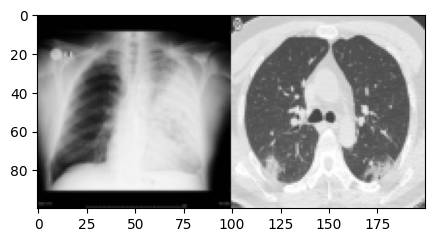

     Normal Chest X-ray Vs Covid-19 Chest X-ray


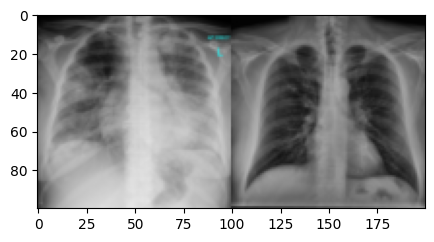

     Normal Chest X-ray Vs Covid-19 Chest X-ray


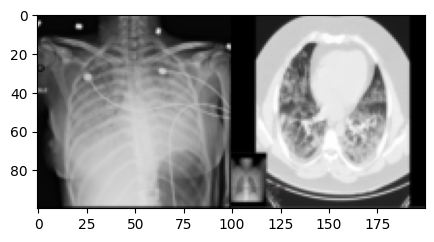

In [ ]:
covid_dir = os.path.join(os.getcwd(), 'covid')
normal_dir = os.path.join(os.getcwd(), 'normal')
covid_image = os.listdir(covid_dir)[:10]
normal_image = os.listdir(normal_dir)[:10]

# Load and display the images

def plotter(i):
    image_path = os.path.join(covid_dir,covid_image[i])
    covidimage = cv2.imread(image_path)
    image_path = os.path.join(normal_dir,normal_image [i])
    normalimage = cv2.imread(image_path)

    covidimage = skimage.transform.resize(covidimage , (100, 100, 3))
    normalimage= skimage.transform.resize(normalimage, (100, 100, 3))

    #coronavirus = skimage.transform.resize(coronavirus, (100, 100, 3) , mode = 'reflect')
    pair = np.concatenate((normalimage,covidimage), axis=1)
    print("     Normal Chest X-ray Vs Covid-19 Chest X-ray")
    plt.figure(figsize=(5,5))
    plt.imshow(pair)
    plt.show()
for i in range(3,6):
    plotter(i)

2. Clean or preprocess dataset:



The dataset can be preprocessed using various techniques such as resizing, normalization, and data augmentation

In [ ]:
# resizing the images:
# Set the paths to the COVID-19 and normal images directories
covid_dir = os.path.join(os.getcwd(), 'covid')
normal_dir = os.path.join(os.getcwd(), 'normal')

# Set the image size
image_size = (224, 224)

# Initialize the data and labels lists
data = []
labels = []

# Load and preprocess the COVID-19 images
for file_name in os.listdir(covid_dir):
    # Load the image
    image_path = os.path.join(covid_dir, file_name)
    image = cv2.imread(image_path)

    # Convert the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image
    image = cv2.resize(image, image_size)

    # Add the image and label to the data and labels lists
    data.append(image)
    labels.append(1)

# Load and preprocess the normal images
for file_name in os.listdir(normal_dir):
    # Load the image
    image_path = os.path.join(normal_dir, file_name)
    image = cv2.imread(image_path)

    # Convert the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image
    image = cv2.resize(image, image_size)

    # Add the image and label to the data and labels lists
    data.append(image)
    labels.append(0)

# Convert the data and labels lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

In [ ]:
print("data=",len(data))
print("labels=",len(labels))

data= 929
labels= 929


In [ ]:
data.shape

(929, 224, 224, 3)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((743, 224, 224, 3), (186, 224, 224, 3), (743,), (186,))

In [ ]:
#Create an instance of the ImageDataGenerator class
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')


# Fit the generator on your data
datagen.fit(X_train)

# Use the generator to augment your data
augmented_data = datagen.flow(X_train, y_train, batch_size=32)


Select and train model.

In [ ]:


# Load the VGG16 model, with weights pre-trained on ImageNet
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Create a new model
vgg_model = models.Sequential()

# Add the VGG16 convolutional base model
vgg_model.add(vgg_conv)

# Add new layers
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(1024, activation='relu'))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(1, activation='sigmoid'))



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

# Load the ResNet50 model, with weights pre-trained on ImageNet
resnet_conv = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers except the last few layers
for layer in resnet_conv.layers[:-4]:
    layer.trainable = False

# Create a new model
resnet_model = models.Sequential()

# Add the ResNet50 convolutional base model
resnet_model.add(resnet_conv)

# Add new layers
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(1024, activation='relu'))
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(layers.Dense(1, activation='sigmoid'))




94765736/94765736 [==============================] - 0s 0us/step


In [ ]:

# Compile the VGG16 model using the Adam optimizer
vgg_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=["accuracy"])

# Train the VGG16 model
vgg_history = vgg_model.fit(augmented_data,
                    steps_per_epoch=len(X_train) // 32,
                    epochs=40,
                    validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
23/23 [==============================] - 28s 648ms/step - loss: 3.0073 - accuracy: 0.5752 - val_loss: 0.6226 - val_accuracy: 0.6559
Epoch 2/40
23/23 [==============================] - 9s 368ms/step - loss: 0.6644 - accuracy: 0.6034 - val_loss: 0.6407 - val_accuracy: 0.5968
Epoch 3/40
23/23 [==============================] - 8s 359ms/step - loss: 0.6711 - accuracy: 0.6259 - val_loss: 0.6188 - val_accuracy: 0.6505
Epoch 4/40
23/23 [==============================] - 10s 403ms/step - loss: 0.6571 - accuracy: 0.6160 - val_loss: 0.6027 - val_accuracy: 0.6237
Epoch 5/40
23/23 [==============================] - 10s 424ms/step - loss: 0.6531 - accuracy: 0.6104 - val_loss: 0.6193 - val_accuracy: 0.6022
Epoch 6/40
23/23 [==============================] - 10s 428ms/step - loss: 0.6247 - accuracy: 0.6484 - val_loss: 0.6147 - val_accuracy: 0.6828
Epoch 7/40
23/23 [==============================] - 9s 396ms/step - loss: 0.6131 - accuracy: 0.6259 - val_loss: 0.6031 - val_accuracy: 0.6398
Ep

In [ ]:
# Compile the ResNet50 model using the Adam optimizer
resnet_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=["accuracy"])

# Train the ResNet50 model
resnet_history = resnet_model.fit(augmented_data,
                    steps_per_epoch=len(X_train) // 32,
                    epochs=40,
                    validation_data=(X_test, y_test))

Epoch 1/40
23/23 [==============================] - 17s 513ms/step - loss: 2.2895 - accuracy: 0.6132 - val_loss: 2.1633 - val_accuracy: 0.6344
Epoch 2/40
23/23 [==============================] - 10s 438ms/step - loss: 1.7691 - accuracy: 0.6906 - val_loss: 0.7592 - val_accuracy: 0.7742
Epoch 3/40
23/23 [==============================] - 9s 397ms/step - loss: 1.2216 - accuracy: 0.7342 - val_loss: 0.9864 - val_accuracy: 0.7043
Epoch 4/40
23/23 [==============================] - 8s 356ms/step - loss: 0.8063 - accuracy: 0.7623 - val_loss: 0.7489 - val_accuracy: 0.7634
Epoch 5/40
23/23 [==============================] - 9s 407ms/step - loss: 0.4637 - accuracy: 0.8274 - val_loss: 0.5372 - val_accuracy: 0.7957
Epoch 6/40
23/23 [==============================] - 12s 505ms/step - loss: 0.4815 - accuracy: 0.8200 - val_loss: 0.6279 - val_accuracy: 0.7581
Epoch 7/40
23/23 [==============================] - 14s 585ms/step - loss: 0.3664 - accuracy: 0.8425 - val_loss: 0.6174 - val_accuracy: 0.7634
Ep

Evaluate the model

In [ ]:

# Evaluate the VGG16 model on the test data
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(X_test, y_test)
print('VGG16 Test accuracy:', vgg_test_acc*100)


6/6 [==============================] - 1s 133ms/step - loss: 0.4918 - accuracy: 0.8656
VGG16 Test accuracy: 86.55914068222046


In [ ]:
# Evaluate the ResNet50 model on the test data
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(X_test, y_test)
print('ResNet50 Test accuracy:', resnet_test_acc*100)

6/6 [==============================] - 1s 100ms/step - loss: 0.6775 - accuracy: 0.7957
ResNet50 Test accuracy: 79.56989407539368


Plotting the training and validation plot with respect to accuracy and loss

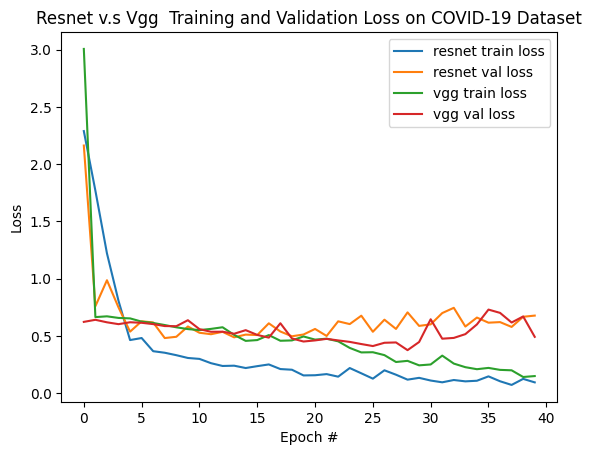

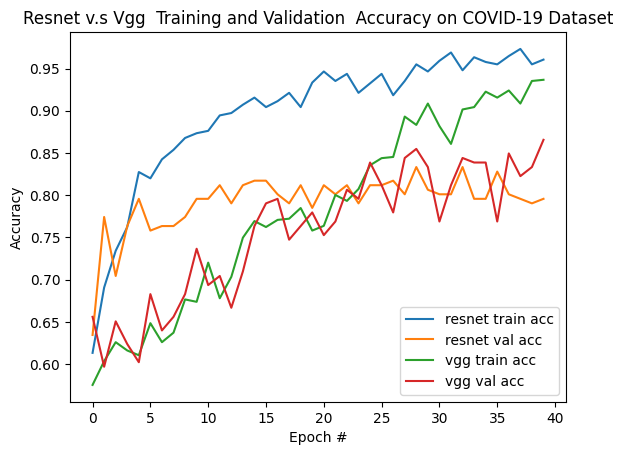

In [ ]:
# plot the loss
plt.plot(resnet_history.history['loss'], label='resnet train loss')
plt.plot(resnet_history.history['val_loss'], label='resnet val loss')
plt.plot(vgg_history.history['loss'], label='vgg train loss')
plt.plot(vgg_history.history['val_loss'], label='vgg val loss')
plt.title("Resnet v.s Vgg  Training and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(resnet_history.history['accuracy'], label='resnet train acc')
plt.plot(resnet_history.history['val_accuracy'], label='resnet val acc')
plt.plot(vgg_history.history['accuracy'], label='vgg train acc')
plt.plot(vgg_history.history['val_accuracy'], label='vgg val acc')
plt.title("Resnet v.s Vgg  Training and Validation  Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Deploy the model

Saving the best model

In [ ]:
vgg_model.save('Covid_model.h5')

In [ ]:
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.preprocessing import image
from keras.models import load_model
model = tf.keras.models.load_model('Covid_model.h5')

from keras.applications.vgg16 import preprocess_input

1/1 [==============================] - 0s 23ms/step
[[0.63324195]]
1/1 [==============================] - 0s 25ms/step
The model predicts that this is a COVID-19 chest X-ray.


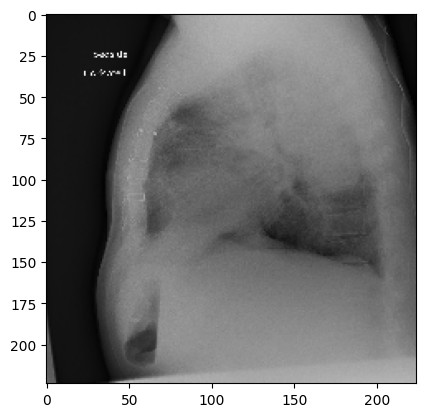

In [ ]:


img = image.load_img('/content/covid/covid-19-pneumonia-15-L.jpg', target_size=(224, 224))
#insert a random covid-19 x-ray image
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes =model.predict(img_data)
print(classes)
prediction = model.predict(img_data)

# Print the prediction
if prediction[0][0] > 0.5:
  print('The model predicts that this is a COVID-19 chest X-ray.')
else:
  print('The model predicts that this is a normal chest X-ray.')



1/1 [==============================] - 0s 22ms/step
[[0.02567281]]
1/1 [==============================] - 0s 23ms/step
The model predicts that this is a normal chest X-ray.


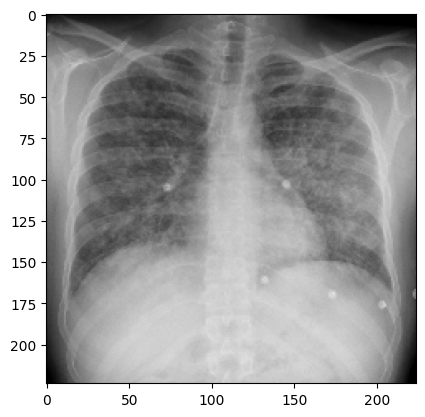

In [ ]:


img = image.load_img('/content/normal/000010-2.png', target_size=(224, 224))
#insert a random covid-19 x-ray image
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)

prediction = model.predict(img_data)

# Print the prediction
if prediction[0][0] > 0.5:
  print('The model predicts that this is a COVID-19 chest X-ray. ')
else:
  print('The model predicts that this is a normal chest X-ray.')